*A project by Jason Roman and Aidan Slusher*

**Project Title**: Analysis of Denver Crash Data Using Random Forest

**INTRO**

In this analysis, we delve into predicting the severity of road crashes in Denver County. Our dataset comes from The Colorado Department of Transportation in the form of a CSV file for each year. We took datasets from the period of 2014-2019 in hopes of getting a more accurate prediction. The original dataset comprises of 131,187 different crashes as well as 86 features that include relevant information about the crash. Additionally, we aim to predict severity through the random forest algorithm because of its ability to handle multi-featured datasets

The following includes all of the libraries that will be used in this analysis:

**METHODOLOGY**

In crafting our methodology, we first compiled a comprehensive Denver crash dataset spanning 2014-2019. Key features such as 'ROAD_DESC,' 'CONDITION,' 'LIGHTING,' 'WEATHER,' 'BELT_1,' and 'DUI_1' were selected for relevance. Data underwent meticulous preprocessing, including merging, date formatting, and handling missing values, while 'SEVERITY_NUMERIC' was introduced for modeling. Beginning with a baseline, we refined our Random Forest model through hyperparameter tuning, assessing performance via learning curves and test set accuracy. Feature importance analysis unveiled critical predictors. Recognizing the potential for enhanced accuracy, we explored additional features like vehicle count and age. The final model, trained with optimized hyperparameters, showcased [provide accuracy]. Results were analyzed, revealing incremental accuracy gains, and future work considerations include further exploration of feature nuances for a deeper understanding of accident severity predictors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In the following code block, we handled reading in the dataset. We utilized the pandas library to read all of the files that we wanted to use for analysis as well as merging them into one dataset with the selected features for ease of use. We selected the best features that could affect the severity of the crash while also trying to pick features containing the least amount of empty values. This was done to make the data preprocessing step as easy as possible.


After processing the data we printed out the head of our final dataset to visualize the final selected features as well as printing the shape of the merged dataset.

In [44]:
crash_files = [
    'DenverCrashData_2014.csv',
    'DenverCrashData_2015.csv',
    'DenverCrashData_2016.csv',
    'DenverCrashData_2017.csv',
    'DenverCrashData_2018.csv',
    'DenverCrashData_2019.csv',
]

crash_dfs = []

selected_features = ['ROAD_DESC', 'CONDITION', 'LIGHTING', 'WEATHER', 'BELT_1', 'DUI_1']

for crash_file in crash_files:
    crash_df = pd.read_csv(crash_file)
    crash_dfs.append(crash_df)

merged_crash_df = pd.concat(crash_dfs, ignore_index=True)

merged_crash_df = merged_crash_df[selected_features + ['SEVERITY']]

merged_crash_df['SEVERITY_NUMERIC'] = pd.factorize(merged_crash_df['SEVERITY'])[0]

print("Dimensions of the final preprocessed dataset:", merged_crash_df.shape)

print(merged_crash_df.head())

Dimensions of the final preprocessed dataset: (131187, 8)
              ROAD_DESC CONDITION      LIGHTING  WEATHER BELT_1 DUI_1  \
0  INTERSECTION RELATED       DRY  DARK-LIGHTED  UNKNOWN    NaN     N   
1      NON-INTERSECTION       DRY  DARK-LIGHTED  UNKNOWN      Y     N   
2       AT INTERSECTION       DRY  DARK-LIGHTED     NONE      Y     N   
3       AT INTERSECTION       DRY  DARK-LIGHTED     NONE      Y     N   
4       AT INTERSECTION       DRY  DARK-LIGHTED  UNKNOWN      N     N   

  SEVERITY  SEVERITY_NUMERIC  
0      PDO                 0  
1      PDO                 0  
2      INJ                 1  
3      PDO                 0  
4      PDO                 0  


**Analysis (1/2)**

We started our analysis with more preprocessing steps. Our dataset contained some features containing NaN values so we started with dropping all of those accidents. Next, we used One-Hot Encoding to convert categorical variables into their features for use in the random forest algorithm.

After all of these preprocessing steps, we were then able to split the data into training and test splits for the classifier.

In [15]:
merged_crash_df.dropna(inplace=True)

merged_crash_df_base_encoded = pd.get_dummies(merged_crash_df, columns=selected_features, drop_first=True)

print("Dimensions of the final one-hot encoded dataset:", merged_crash_df_base_encoded.shape)

X_base = merged_crash_df_base_encoded.drop(['SEVERITY', 'SEVERITY_NUMERIC'], axis=1)
y_base = merged_crash_df_base_encoded['SEVERITY_NUMERIC']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

Dimensions of the final one-hot encoded dataset: (92958, 34)


Here we have our baseline Random Forest Classifier. It runs a random forest test on our preprocessed data to see how our accuracy will improve with our further tests. We got an accuracy of 80.2 percent with this baseline. This score is already a good baseline however we can improve upon that.

In [16]:
# Baseline Random Forest Classifier

rf_classifier_baseline = RandomForestClassifier(random_state=42)

rf_classifier_baseline.fit(X_train_base, y_train_base)

y_pred_baseline = rf_classifier_baseline.predict(X_test_base)

accuracy_baseline = accuracy_score(y_test_base, y_pred_baseline)
print(f"Accuracy of the baseline Random Forest: {accuracy_baseline}")

Accuracy of the baseline Random Forest: 0.8028184165232358


In the next code blocks, we will explore hyperparameter tuning. The goal of tuning the hyperparameters is to find the best hyperparameters for our model that will result in a higher accuracy score. We accomplished this by using the grid search method to test all combinations of hyperparameters.

In [37]:
# Hyperparameter Tuning

param_grid_base = {
    'n_estimators': [50, 100, 150, 300],
    'max_depth': [None, 1, 5, 10, 20]
}

rf_classifier_tuned_base = RandomForestClassifier(random_state=42)

grid_search_base = GridSearchCV(rf_classifier_tuned_base, param_grid_base, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_base.fit(X_train_base, y_train_base)

results_base = pd.DataFrame(grid_search_base.cv_results_)

param_columns = ['param_' + param for param in param_grid_base.keys()]
results_subset_base = results_base[['mean_test_score'] + param_columns]

In [38]:
best_params_base = grid_search_base.best_params_
print("Best Hyperparameters:", best_params_base)

best_rf_model_base = grid_search_base.best_estimator_

y_pred_tuned_base = best_rf_model_base.predict(X_test_base)

accuracy_tuned_base = accuracy_score(y_test_base, y_pred_tuned_base)
print(f"Accuracy on the test set with tuned hyperparameters: {accuracy_tuned_base}")

Best Hyperparameters: {'max_depth': 1, 'n_estimators': 50}
Accuracy on the test set with tuned hyperparameters: 0.8047009466437177


**Plot-1**

In this plot, we wanted to visualize how similar the hyperparameters were from each other in terms of accuracy score. From the provided bar graph, we can see tiny differences that changing our hyperparameters has on our accuracy. This is still important however because the goal is to get the most accurate prediction and any increase helps us with that.

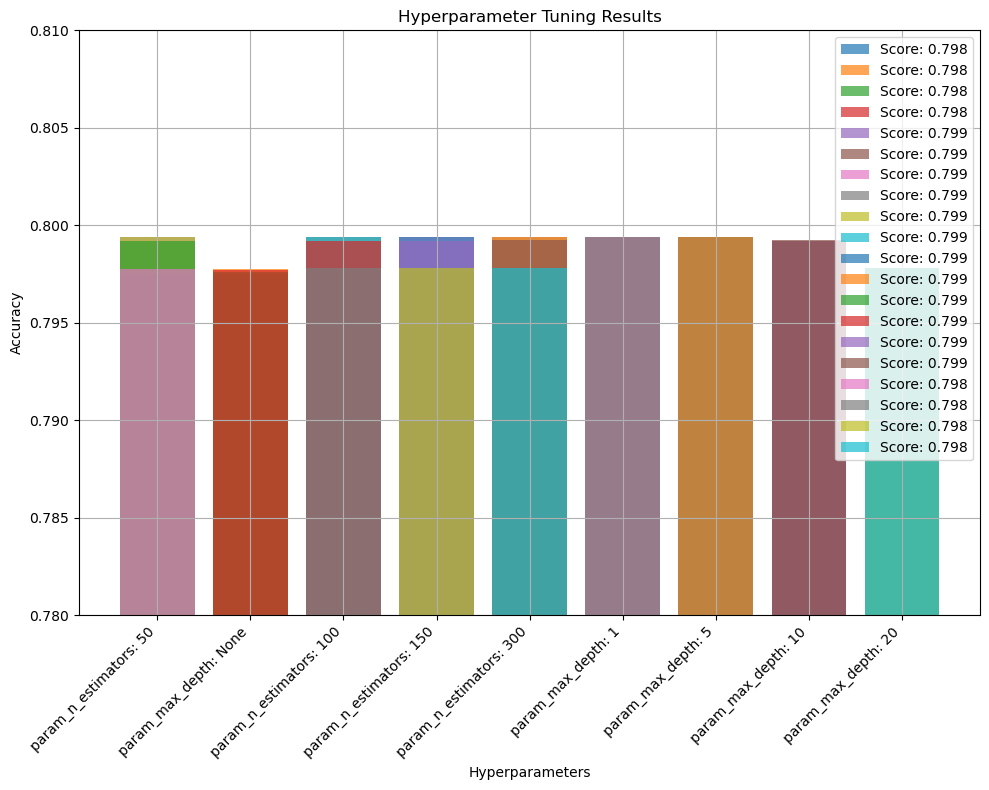

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

for index, row in results_subset_base.iterrows():
    hyperparam_values = [f"{param}: {row[param]}" for param in param_columns]
    
    mean_test_score_array = np.full(len(hyperparam_values), row['mean_test_score'])
    
    ax.bar(hyperparam_values, mean_test_score_array, label=f"Score: {row['mean_test_score']:.3f}", alpha=0.7)

ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Accuracy')
ax.set_title('Hyperparameter Tuning Results')
ax.legend()
ax.grid(True)

plt.xticks(rotation=45, ha="right")

plt.ylim(0.78, 0.81)

plt.tight_layout()
plt.show()

**Plot-2**

The feature importance plot illustrates the significance of each predictor in the Random Forest model for predicting crash severity. Displayed as a horizontal bar chart, it visualizes the contribution of individual features to the model's decision-making process. Features are listed along the y-axis, while the x-axis represents the corresponding importance scores. This informative visualization aids in identifying key factors influencing the model's predictions, offering insights into the relative influence of each feature on the overall predictive performance.

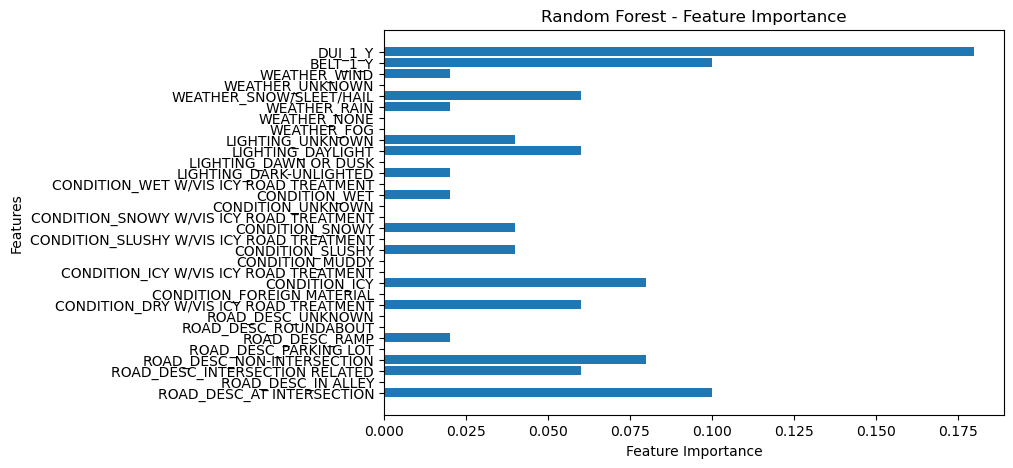

In [40]:
feature_importances = best_rf_model_base.feature_importances_
features = X_train_base.columns

plt.figure(figsize=(8, 5))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.show()


**Plot-3**

The learning curve illustrates the model's performance in terms of accuracy as a function of the number of training samples. It consists of two curves: one depicting the training accuracy and the other showing the validation accuracy. The x-axis represents the number of training samples, while the y-axis indicates the corresponding accuracy scores. This visualization is valuable for assessing how well the model generalizes to unseen data and understanding the impact of additional training samples on overall performance.

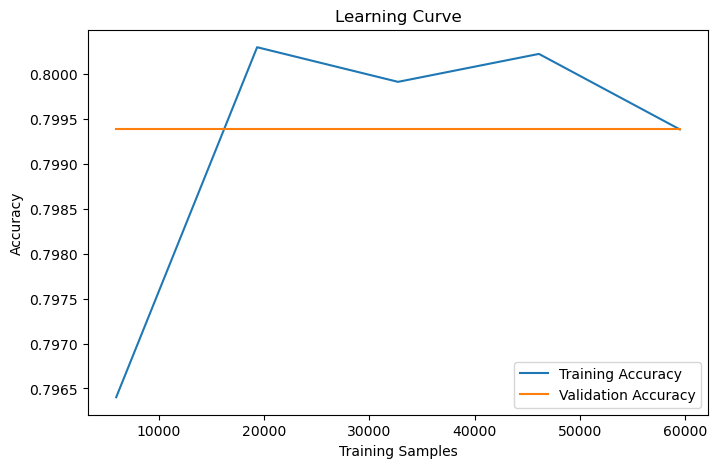

In [41]:
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model_base, X_train_base, y_train_base, cv=5, scoring='accuracy', n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


**Analysis (2/2)**

The following code block evaluates our final Random Forest classifier's performance with optimal hyperparameters (max_depth=10, n_estimators=150). After initializing the model, a subset of the dataset is sampled for expedited training using a fixed number of training samples for maximum accuracy. The model is trained, and accuracy is calculated on the original test set. Our final model's accuracy was 80.6 percent accurate.

In [49]:
best_max_depth = 10
best_n_estimators = 300

num_training_samples = 18500

best_rf_classifier = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)

sampled_data = merged_crash_df_base_encoded.sample(n=num_training_samples, random_state=42)

X_best = sampled_data.drop(['SEVERITY', 'SEVERITY_NUMERIC'], axis=1)
y_best = sampled_data['SEVERITY_NUMERIC']

best_rf_classifier.fit(X_best, y_best)

y_pred_best = best_rf_classifier.predict(X_test_base)

accuracy_best = accuracy_score(y_test_base, y_pred_best)
print(f"Accuracy on the test set with the best hyperparameters and {num_training_samples} training samples: {accuracy_best}")

Accuracy on the test set with the best hyperparameters and 18500 training samples: 0.8068524096385542


**Discussion of Results**

In our experimental analysis, the developed classifier demonstrated an 80.68% accuracy in predicting accident severity based on the selected features. While the improvement over the baseline test without any optimization is relatively modest (80.28% accuracy), every incremental increase is welcomed. The optimized model, with fine-tuned hyperparameters and feature selection, showcases the efficacy of our approach. This enhancement suggests that the model, even with a marginal boost in accuracy, is better equipped to discern patterns and relationships within the chosen features, contributing to a more reliable prediction of accident severity compared to the baseline configuration. The iterative optimization process underscores the importance of careful tuning for incremental gains in predictive performance.

**Final Thoughts and Areas of Improvement**

In our analysis, we opted for generalizations given the dataset's substantial scale, aiming to enhance compatibility with our Random Forest algorithm. To further improve accuracy, we recognize the potential value of incorporating additional relevant features. For instance, including the number of vehicles involved or the age of the individuals implicated in accidents could provide nuanced insights. These supplementary details may capture complexities influencing accident severity, enriching the model's understanding. By expanding the feature set, we aim to refine the model's predictive capabilities and uncover latent patterns, facilitating a more comprehensive and accurate assessment of the factors contributing to accident severity.

**Team Member Contributions**

Jason - Parsed in the dataset and worked on the different versions of our random forest tests

Aidan - Plotted and effectively visualized our findings.

Both group members worked on the writing and explanations of the process.

**Refrences**

Dataset - https://www.codot.gov/